First we need to extract data from sqlite database.
Database was downloaded from smartphone using android backup.

In [2]:
def get_data_from_file(db_file):
    import sqlite3
    
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        cur = conn.cursor()
        cur.execute("SELECT * FROM accelerometer_data")
        rows = cur.fetchall()
        conn.close()
        return rows
    except Error as e:
        print(e)
        return None

In [3]:
data = get_data_from_file('../accelerometer_data.db')

In [4]:
import pandas as pd
df = pd.DataFrame(data, columns = ['id', 'coor_x', 'coor_y', 'coor_z', 'timestamp', 'activity'])
df = df.drop(columns = ['id'])
df.head()

,coor_x,coor_y,coor_z,timestamp,activity
0,1.381454,4.313154,8.368932,1575470973260,WALKING
1,0.183156,5.242105,11.680113,1575470973393,WALKING
2,-0.823605,2.134431,8.748413,1575470973527,WALKING
3,0.882263,2.390610,6.970718,1575470973660,WALKING
4,-0.363919,4.357447,7.726089,1575470973795,WALKING


In [5]:
#normalise
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[['coor_x', 'coor_y', 'coor_z']] = scaler.fit_transform(df[['coor_x', 'coor_y', 'coor_z']])
x_data = df[['coor_x', 'coor_y', 'coor_z']]

In [6]:
import sys
sys.path.append('../') #the ROCKET project is in parent directory

from rocket_master.code.rocket_functions import generate_kernels, apply_kernels

In [12]:
# generate random kernels
kernels = generate_kernels(input_length = x_data.shape[1], num_kernels = 10_000)
kernels[0][100] #example kernel, in form: weights, lengths, biases, dilations, paddings

array([-0.85270026, -2.27419443, -0.15026421,  0.81978052,  1.51238866,
       -0.12832685,  0.92640718, -0.9655424 ,  1.15752771,  0.12949399,
       -0.1745699 ])

In [13]:
x_transformed = apply_kernels(x_data.to_numpy(), kernels)
x_transformed[0]

array([ 0.        , -0.47944265,  1.        , ..., -0.43645504,
        0.        , -0.99301408])

In [14]:
from sklearn.model_selection import train_test_split

#split data for train and test dataset
x_train, x_test, y_train, y_test = train_test_split(x_transformed, df[['activity']], test_size=0.1, random_state=42)

In [15]:
import numpy as np
from sklearn.linear_model import RidgeClassifierCV

classifier = RidgeClassifierCV(alphas = np.logspace(-3, 3, 10), normalize = True)
classifier.fit(x_train, y_train.to_numpy().ravel())


RidgeClassifierCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                  class_weight=None, cv=None, fit_intercept=True,
                  normalize=True, scoring=None, store_cv_values=False)

In [49]:
predictions = classifier.predict(x_test)

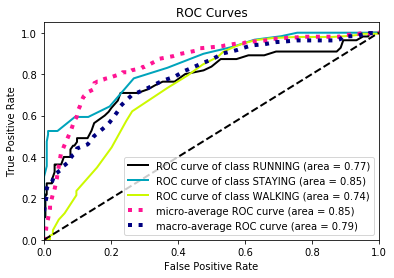

In [19]:
import scikitplot as skplt
decs = classifier.decision_function(x_test)

skplt.metrics.plot_roc(y_test, decs)

In [57]:
from sklearn.metrics import precision_recall_fscore_support

print('Weighted average:')
labels = ['STAYING', 'WALKING', 'RUNNING']
precision, recall, fscore, support = precision_recall_fscore_support(y_test, predictions, labels=labels, average = 'weighted')
for name, score in [('Precision', precision), ('Recall', recall), ('F-score', fscore)]:
    print(f'{name} ratio = {score}')

print()
labels = ['STAYING', 'WALKING', 'RUNNING']
precision, recall, fscore, support = precision_recall_fscore_support(y_test, predictions, labels=labels)

for name, score in [('Precision', precision), ('Recall', recall), ('F-score', fscore), ('Support', support)]:
    print(f'{name} ratio:')
    for activity_no in range(3):
        print(f'\t{labels[activity_no]} = {score[activity_no]}')

Weighted average:
Precision ratio = 0.7781215928560303
Recall ratio = 0.7216828478964401
F-score ratio = 0.6702355167222147

Precision ratio:
	STAYING = 1.0
	WALKING = 0.6981818181818182
	RUNNING = 0.8235294117647058
Recall ratio:
	STAYING = 0.288135593220339
	WALKING = 0.9846153846153847
	RUNNING = 0.2545454545454545
F-score ratio:
	STAYING = 0.4473684210526315
	WALKING = 0.8170212765957446
	RUNNING = 0.38888888888888884
Support ratio:
	STAYING = 59
	WALKING = 195
	RUNNING = 55


In [ ]:
#check when predictions are wrong
# test_df = pd.DataFrame(y_test[predictions != y_test['activity']])
# test_df['predicted'] = predictions[predictions != y_test['activity']]
# test_df

As we can see, the model predictions are pretty good (about 70 %).
We should remember, that very small dataset was used (also with some mistakes), as well as the raw data was loaded - we could have group it into eg. 3-seconds frames, but it wouldn't be apropriate for ROCKET.
